In [58]:
import pandas as pd
import matplotlib.pyplot as plt
from category_encoders import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import r2_score


IMPORT 

In [41]:
def wrangle(filepath):
    df = pd.read_csv(filepath)

    # SUBSET DATA
    mask_year = df["month"].str.contains("2024")
    df = df[mask_year]
    
    # CONVERT REMAINING LEASE TO YEARS ONLY 
    def convert(lease):
        lease_list = lease.replace(" years", "").replace(" months", "").split(" ")
        years = int(lease_list[0])
        months = int(lease_list[1]) if len(lease_list) > 1 else 0
        return years + months/12
    df["remaining_lease"] = df["remaining_lease"].apply(convert)

    # DROP IRRELEVANT, LOW OR HIGH CARDINALITY CATEGORICAL VARIABLES
    df.drop(columns = ["month", "block", "street_name", "lease_commence_date"], inplace = True)
    
    # REMOVE OUTLIERS 
    low, high = df["floor_area_sqm"].quantile([0.1, 0.9])
    mask_area = df["floor_area_sqm"].between(low, high)
    df = df[mask_area]

    return df

In [42]:
df = wrangle("ResaleflatpricesbasedonregistrationdatefromJan2017onwards.csv")
df.head()

,town,flat_type,storey_range,floor_area_sqm,flat_model,remaining_lease,resale_price
169172,ANG MO KIO,3 ROOM,01 TO 03,70.0,Model A,87.750000,520000.0
169173,ANG MO KIO,3 ROOM,25 TO 27,70.0,Model A,87.750000,650000.0
169174,ANG MO KIO,3 ROOM,04 TO 06,67.0,New Generation,53.083333,343800.0
169175,ANG MO KIO,3 ROOM,01 TO 03,88.0,New Generation,52.500000,450000.0
169176,ANG MO KIO,3 ROOM,10 TO 12,68.0,New Generation,56.083333,380000.0


EXPLORE

In [43]:
# CHECK MISSING DATA, CORRECT DATA TYPES
df.info() 

<class 'pandas.core.frame.DataFrame'>
Index: 22513 entries, 169172 to 196888
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   town             22513 non-null  object 
 1   flat_type        22513 non-null  object 
 2   storey_range     22513 non-null  object 
 3   floor_area_sqm   22513 non-null  float64
 4   flat_model       22513 non-null  object 
 5   remaining_lease  22513 non-null  float64
 6   resale_price     22513 non-null  float64
dtypes: float64(3), object(4)
memory usage: 1.4+ MB


In [44]:
# CHECK DATA DISTRIBUTION
df.describe()

,floor_area_sqm,remaining_lease,resale_price
count,22513.000000,22513.000000,2.251300e+04
mean,94.319544,75.060532,6.132534e+05
std,16.514160,14.887669,1.679960e+05
min,67.000000,40.916667,2.750000e+05
25%,84.000000,60.666667,5.000000e+05
50%,93.000000,75.333333,5.900000e+05
75%,109.000000,90.583333,6.900000e+05
max,123.000000,95.416667,1.588000e+06


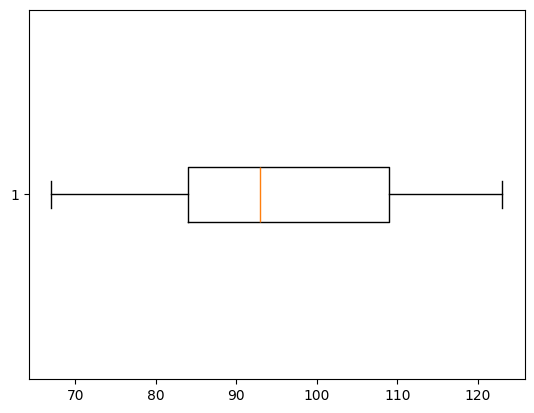

In [45]:
# IDENTIFY OUTLIERS 
plt.boxplot(df["floor_area_sqm"], vert = False);

SPLIT

In [46]:
features = ["town", "flat_type", "storey_range", "floor_area_sqm", "flat_model", "remaining_lease"]
X = df[features]
target = "resale_price"
y = df[target]

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

BASELINE

In [53]:
y_mean = y_train.mean()
print("Mean apt price:", y_mean)

Mean apt price: 613538.5885363687


In [60]:
y_pred_baseline = [y_mean] * len(y_train)
print("Baseline MAE:", mean_absolute_error(y_train, y_pred_baseline))
print("Training R-squared score:", r2_score(y_train, y_pred_baseline))

Baseline MAE: 126323.64274397423
Training R-squared score: 0.0


ITERATE

In [54]:
model = make_pipeline(
    OneHotEncoder(use_cat_names = True),
    LinearRegression()
)
model.fit(X_train, y_train)

,steps,"[('onehotencoder', ...), ('linearregression', ...)]"
,transform_input,None
,memory,None
,verbose,False
,verbose,0
,cols,"['town', 'flat_type', ...]"
,drop_invariant,False
,return_df,True
,handle_missing,'value'
,handle_unknown,'value'
,use_cat_names,True


EVALUATE

In [59]:
y_pred_training = model.predict(X_train)
print("Training MAE:", mean_absolute_error(y_train, y_pred_training))
print("Training R-squared score:", r2_score(y_train, y_pred_training))

Training MAE: 48292.40945140941
Training R-squared score: 0.8556921433875397


TEST

In [61]:
y_pred_test = model.predict(X_test)
print("Training MAE:", mean_absolute_error(y_test, y_pred_test))
print("Training R-squared score:", r2_score(y_test, y_pred_test))

Training MAE: 49475.85497264503
Training R-squared score: 0.845880943432203


RESULTS

In [64]:
feature_names = model.named_steps["onehotencoder"].get_feature_names()
feature_names[:5]

C:\Users\rayvi\AppData\Local\Temp\ipykernel_11980\1931957030.py:1: FutureWarning: `get_feature_names` is deprecated in all of sklearn. Use `get_feature_names_out` instead.
  feature_names = model.named_steps["onehotencoder"].get_feature_names()


array(['town_WOODLANDS', 'town_CHOA CHU KANG', 'town_BUKIT BATOK',
       'town_PUNGGOL', 'town_HOUGANG'], dtype=object)

In [66]:
coefficients = model.named_steps["linearregression"].coef_
coefficients[:5]

array([-138706.19955594, -164878.13647713,  -97687.12827525,
       -102237.46056275,  -70345.59946611])

In [77]:
feat_imp = pd.Series(coefficients, index = feature_names)
feat_imp.head()

town_WOODLANDS       -138706.199556
town_CHOA CHU KANG   -164878.136477
town_BUKIT BATOK      -97687.128275
town_PUNGGOL         -102237.460563
town_HOUGANG          -70345.599466
dtype: float64

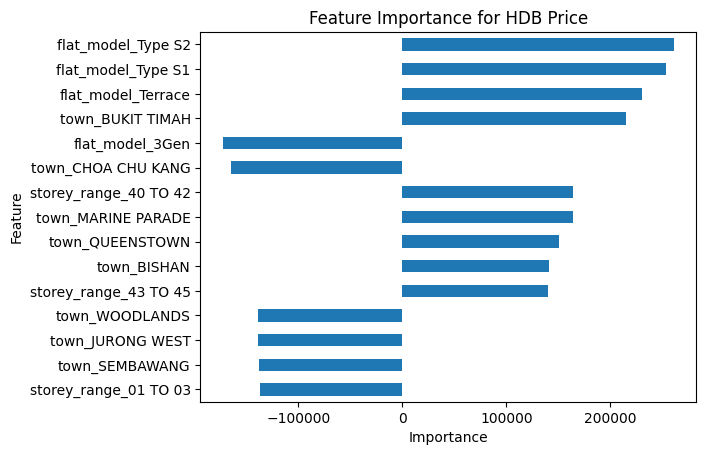

In [80]:
feat_imp.sort_values(key = abs).tail(15).plot(kind = "barh")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importance for HDB Price");
